#  Dependecies

In [1]:
!pip3 install -U ncps pytorch-lightning

In [2]:
import numpy as np
import torch.nn as nn
from ncps.wirings import AutoNCP
from ncps.torch import LTC
import pytorch_lightning as pl
import torch
import torch.utils.data as data
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns


# Occupancy dataset

In [3]:
# LightningModule for training a RNNSequence module
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)
        self.log("train_loss", loss, prog_bar=True)
        return {"loss": loss}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model.forward(x)
        y_hat = y_hat.view_as(y)
        loss = nn.MSELoss()(y_hat, y)

        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        # Here we just reuse the validation_step for testing
        return self.validation_step(batch, batch_idx)

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)


In [4]:
import pandas as pd
def read_file(filename):
    df = pd.read_csv(filename)

    data_x = np.stack([
        df['Temperature'].values,
        df['Humidity'].values,
        df['Light'].values,
        df['CO2'].values,
        df['HumidityRatio'].values,
        ],axis=-1)
    data_y = df['Occupancy'].values.astype(np.int32)
    return data_x,data_y

def cut_in_sequences(x,y,seq_len,inc=1):

    sequences_x = []
    sequences_y = []

    for s in range(0,x.shape[0] - seq_len,inc):
        start = s
        end = start+seq_len
        sequences_x.append(x[start:end])
        sequences_y.append(y[start:end])

    return np.stack(sequences_x,axis=1),np.stack(sequences_y,axis=1)

class OccupancyData:
    def __init__(self, seq_len=16):
        train_x, train_y = read_file("data/occupancy/datatraining.txt")
        test0_x, test0_y = read_file("data/occupancy/datatest.txt")
        test1_x, test1_y = read_file("data/occupancy/datatest2.txt")

        # Normalize
        mean_x = np.mean(train_x, axis=0)
        std_x = np.std(train_x, axis=0)
        train_x = (train_x - mean_x) / std_x
        test0_x = (test0_x - mean_x) / std_x
        test1_x = (test1_x - mean_x) / std_x

        # Cut into sequences
        train_x, train_y = cut_in_sequences(train_x, train_y, seq_len)
        test0_x, test0_y = cut_in_sequences(test0_x, test0_y, seq_len, inc=8)
        test1_x, test1_y = cut_in_sequences(test1_x, test1_y, seq_len, inc=8)

        # Split into train/valid
        permutation = np.random.RandomState(893429).permutation(train_x.shape[1])
        valid_size = int(0.1 * train_x.shape[1])
        self.valid_x = train_x[:, permutation[:valid_size]]
        self.valid_y = train_y[:, permutation[:valid_size]]
        self.train_x = train_x[:, permutation[valid_size:]]
        self.train_y = train_y[:, permutation[valid_size:]]

        # Concatenate test data
        self.test_x = np.concatenate([test0_x, test1_x], axis=1)
        self.test_y = np.concatenate([test0_y, test1_y], axis=1)

        print("Original train_x shape:", train_x.shape)  # Should be (seq_len, num_sequences, 5)
        print("Original train_y shape:", train_y.shape)  # Should be (seq_len, num_sequences)

        # Transpose and reshape for PyTorch compatibility
        self.train_x = np.transpose(train_x, (1, 0, 2)).astype(np.float32)  # (num_sequences, seq_len, 5)
        self.train_y = np.transpose(train_y, (1, 0))[:, :, np.newaxis].astype(np.float32)  # (num_sequences, seq_len, 1)

        self.valid_x = np.transpose(self.valid_x, (1, 0, 2)).astype(np.float32)
        self.valid_y = np.transpose(self.valid_y, (1, 0))[:, :, np.newaxis].astype(np.float32)

        self.test_x = np.transpose(self.test_x, (1, 0, 2)).astype(np.float32)
        self.test_y = np.transpose(self.test_y, (1, 0))[:, :, np.newaxis].astype(np.float32)

        print("Transposed train_x shape:", self.train_x.shape)  # Should be (seq_len, num_sequences, 5)
        print("Transposed train_y shape:", self.train_y.shape)  # Should be (seq_len, num_sequences)


In [5]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
import os
os.makedirs('data/occupancy', exist_ok=True)

# Unzip directly into the data directory
!unzip occupancy_data.zip -d data/occupancy/

# Clean up the zip file
!rm occupancy_data.zip

# Verify the file structure
print("Contents of data directory:")
!ls -l data/occupancy/

--2025-03-17 13:05:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘occupancy_data.zip’

occupancy_data.zip      [ <=>                ] 327.84K  --.-KB/s    in 0.04s   

2025-03-17 13:05:14 (7.67 MB/s) - ‘occupancy_data.zip’ saved [335713]

Archive:  occupancy_data.zip
  inflating: data/occupancy/datatest.txt  
  inflating: data/occupancy/datatest2.txt  
  inflating: data/occupancy/datatraining.txt  
Contents of data directory:
total 1468
-rw-r--r-- 1 root root 699664 Jan  5  2016 datatest2.txt
-rw-r--r-- 1 root root 200766 Jan  5  2016 datatest.txt
-rw-r--r-- 1 root root 596674 Jan  5  2016 datatraining.txt


In [10]:
occupancy = OccupancyData(seq_len=16)

train_dataset = data.TensorDataset(
    torch.from_numpy(occupancy.train_x),
    torch.from_numpy(occupancy.train_y)
)
valid_dataset = data.TensorDataset(
    torch.from_numpy(occupancy.valid_x),
    torch.from_numpy(occupancy.valid_y)
)
test_dataset = data.TensorDataset(
    torch.from_numpy(occupancy.test_x),
    torch.from_numpy(occupancy.test_y)
)

# Create DataLoaders
batch_size = 16
train_loader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
valid_loader = data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Adjust model parameters for the new dataset
in_features = 5  # Number of input features
out_features = 1  # Output (regression target)

Original train_x shape: (16, 8127, 5)
Original train_y shape: (16, 8127)
Transposed train_x shape: (8127, 16, 5)
Transposed train_y shape: (8127, 16, 1)


In [58]:
occupancy.train_x.shape

(8127, 16, 5)

Next we define some toy dataset and create the corresponding DataLoaders

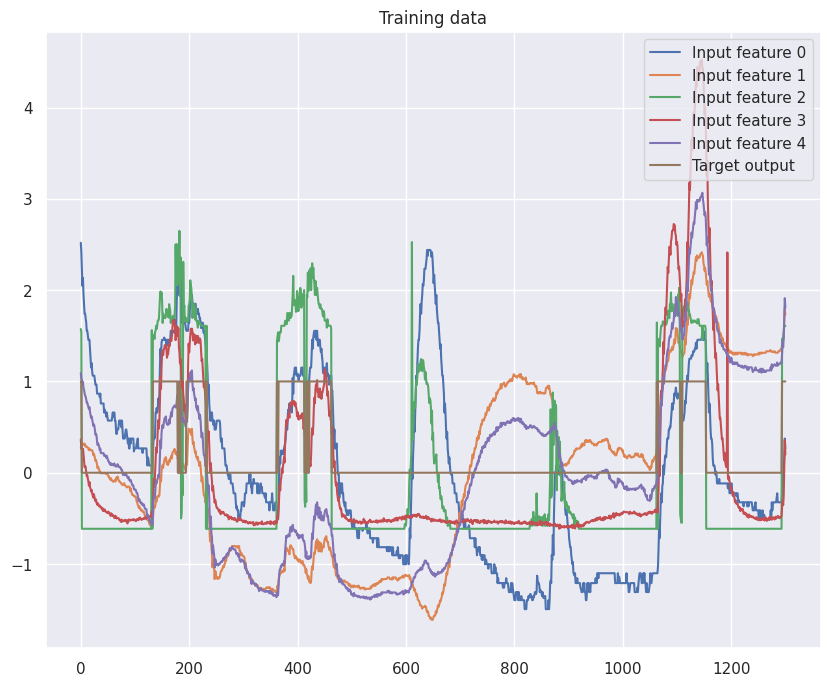

In [71]:


# Let's visualize the training data
sns.set()
plt.figure(figsize=(10, 8))
plt.plot(occupancy.train_x.reshape(-1,5)[::100,0], label="Input feature 0")
plt.plot(occupancy.train_x.reshape(-1,5)[::100,1], label="Input feature 1")
plt.plot(occupancy.train_x.reshape(-1,5)[::100,2], label="Input feature 2")
plt.plot(occupancy.train_x.reshape(-1,5)[::100,3], label="Input feature 3")
plt.plot(occupancy.train_x.reshape(-1,5)[::100,4], label="Input feature 4")
plt.plot(occupancy.train_y.reshape(-1)[::100], label="Target output")
#plt.ylim((-1, 1))
plt.title("Training data")
plt.legend(loc="upper right")
plt.show()

Here we can finally create a LTCCell and make use of the predefined sparse wiring structures of the keras-ncp package. For simplicity we will just define a fully-connected RNN

In [109]:
wiring = AutoNCP(256, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=40,
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


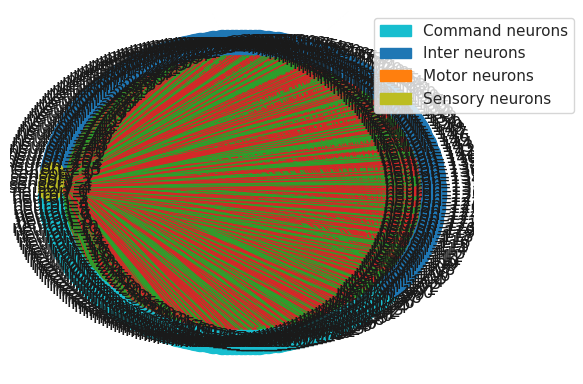

In [80]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

(1549, 16, 1)


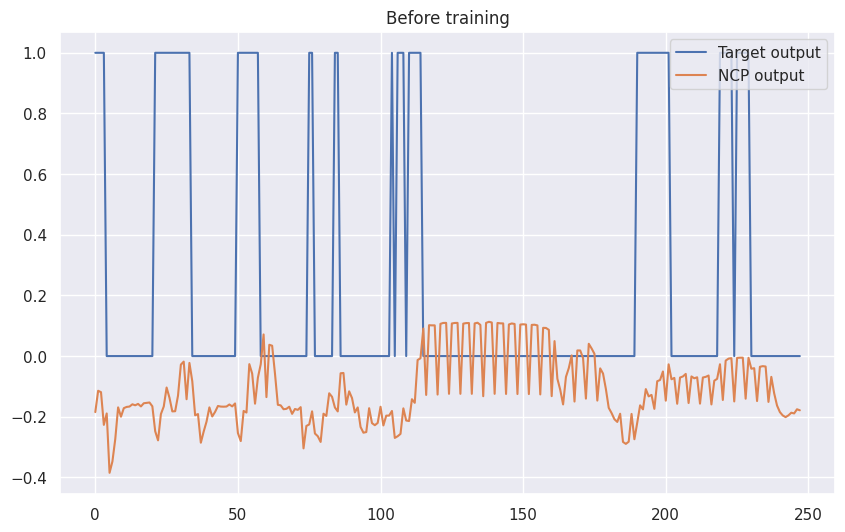

In [69]:
sns.set()
with torch.no_grad():
    # Extract input tensor from test dataset (features only)
    test_inputs = test_dataset.tensors[0]  # Shape: [num_sequences, seq_len, features]

    # Get predictions
    prediction, _ = ltc_model(test_inputs)  # Forward pass returns (output, hidden_state)
    prediction = prediction.numpy()
print(prediction.shape)
plt.figure(figsize=(10, 6))
# Plot first sequence
plt.plot(occupancy.test_y.reshape(-1)[::100], label="Target output")
plt.plot(prediction.reshape(-1)[::100], label="NCP output")
#plt.ylim((-1, 1))
plt.title("Before training")
plt.legend(loc="upper right")
plt.show()

... and train our network

In [78]:
trainer.fit(learn, train_loader,valid_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | LTC  | 6.0 K  | train
---------------------------------------
4.8 K     Trainable params
1.2 K     Non-trainable params
6.0 K     Total params
0.024     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [74]:
results = trainer.test(learn, test_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    0.06083209440112114    │
└───────────────────────────┴───────────────────────────┘

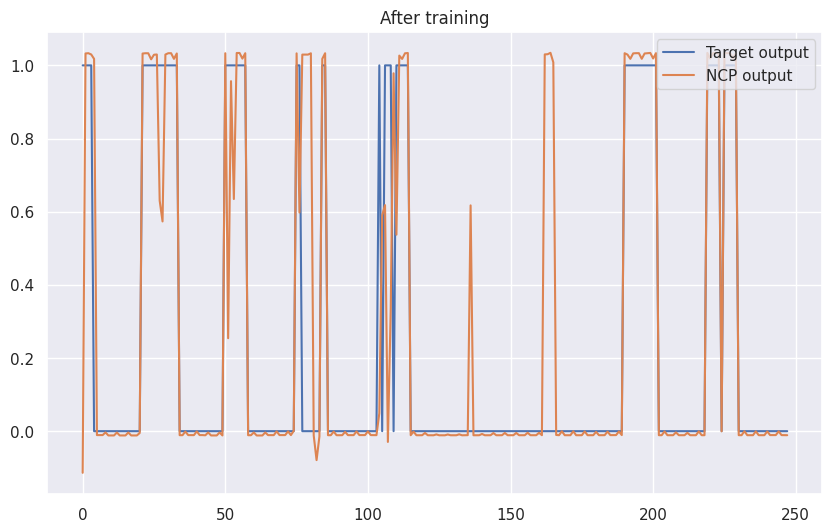

In [75]:
sns.set()
with torch.no_grad():
    # Extract input tensor from test dataset (features only)
    test_inputs = test_dataset.tensors[0]  # Shape: [num_sequences, seq_len, features]

    # Get predictions
    prediction, _ = ltc_model(test_inputs)  # Forward pass returns (output, hidden_state)
    prediction = prediction.numpy()
plt.figure(figsize=(10, 6))
# Plot first sequence
plt.plot(occupancy.test_y.reshape(-1)[::100], label="Target output")
plt.plot(prediction.reshape(-1)[::100], label="NCP output")
#plt.ylim((-1, 1))
plt.title("After training")
plt.legend(loc="upper right")
plt.show()

# Sequantial MNIST dataset

In [3]:
class SequenceLearner(pl.LightningModule):
    def __init__(self, model, lr=0.005):
        super().__init__()
        self.model = model
        self.lr = lr
        self.loss_fn = nn.CrossEntropyLoss()  # Changed from MSELoss

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model(x)
        loss = self.loss_fn(y_hat, y)  # Shape: (batch_size, 10) vs (batch_size)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat, _ = self.model(x)
        loss = self.loss_fn(y_hat, y)
        acc = (y_hat.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss)
        self.log("val_acc", acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=self.lr)

In [4]:
class SequentialMNIST(data.Dataset):
    def __init__(self, train=True, validation=False):
        # Load full dataset
        full_dataset = MNIST(
            root='./data',
            train=train,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: x.view(28, 28))
            ])
        )

        # Split into train/validation if needed
        if train and validation:
            # Use last 10% of training data for validation
            self.dataset = torch.utils.data.Subset(full_dataset,
                                                 range(len(full_dataset)-6000,
                                                 len(full_dataset)))
        elif train:
            # Use first 90% for training
            self.dataset = torch.utils.data.Subset(full_dataset,
                                                 range(0, len(full_dataset)-6000))
        else:
            self.dataset = full_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        img, label = self.dataset[idx]
        sequence = img.view(-1, 1)  # (784, 1)
        return sequence, label


In [5]:
# Create datasets
batch_size = 32
train_dataset = SequentialMNIST(train=True, validation=False)
val_dataset = SequentialMNIST(train=True, validation=True)
test_dataset = SequentialMNIST(train=False)

# Create DataLoaders
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

in_features = 1  # Number of input features
out_features = 10  # Output (regression target)

In [6]:
wiring = AutoNCP(64, out_features)  # 16 units, 1 motor neuron

ltc_model = LTC(in_features, wiring, batch_first=True,return_sequences=False)
learn = SequenceLearner(ltc_model, lr=0.01)
trainer = pl.Trainer(
    logger=pl.loggers.CSVLogger("log"),
    max_epochs=40,
    accumulate_grad_batches=4,  # Effective batch size = 32*4=128
    precision="16-mixed",
    gradient_clip_val=1,  # Clip gradient to stabilize training
)

INFO:pytorch_lightning.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


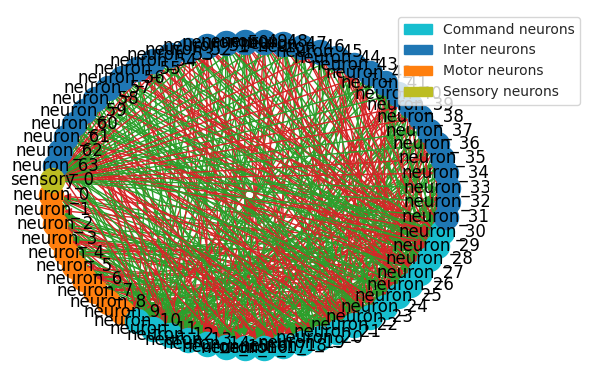

In [7]:
sns.set_style("white")
plt.figure(figsize=(6, 4))
legend_handles = wiring.draw_graph(draw_labels=True,  neuron_colors={"command": "tab:cyan"})
plt.legend(handles=legend_handles, loc="upper center", bbox_to_anchor=(1, 1))
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [8]:
test_dataset[999][0].__len__()

784

In [12]:
# sns.set()
# all_labels = [test_dataset[i][1] for i in range(len(test_dataset))]
# with torch.no_grad():
#     # Extract input tensor from test dataset (features only)
#     test_inputs = torch.from_numpy(np.array([test_dataset[i][0] for i in range(len(test_dataset))]))  # Shape: [num_sequences, seq_len, features]
#     # Get predictions
#     prediction, _ = ltc_model(test_inputs)  # Forward pass returns (output, hidden_state)
#     prediction = prediction.numpy()
# print(prediction.shape)
# plt.figure(figsize=(10, 6))
# # Plot first sequence
# plt.plot(all_labels, label="Target output")
# plt.plot(prediction.reshape(-1)[::100], label="NCP output")
# #plt.ylim((-1, 1))
# plt.title("Before training")
# plt.legend(loc="upper right")
# plt.show()

KeyboardInterrupt: 

In [ ]:
trainer.fit(learn, train_loader,val_loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | LTC              | 21.0 K | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
16.9 K    Trainable params
4.2 K     Non-trainable params
21.0 K    Total params
0.084     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
results = trainer.test(learn, test_loader)